In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as DT
import matplotlib.dates

# Preprocess the data (exploratory work, quality&coherency check)

In [133]:
#import driver data from csv
driver = pd.read_csv('driver_ids.csv')

driver['driver_onboard_date'] = pd.to_datetime(driver['driver_onboard_date']).dt.date
#check driver data basic summary 
driver.describe()


,driver_id,driver_onboard_date
count,937,937
unique,937,49
top,a85adc80be31a10c23b7aaf380e39173,2016-04-05
freq,1,36


In [134]:
#no missing values
driver.isnull().sum()

driver_id              0
driver_onboard_date    0
dtype: int64

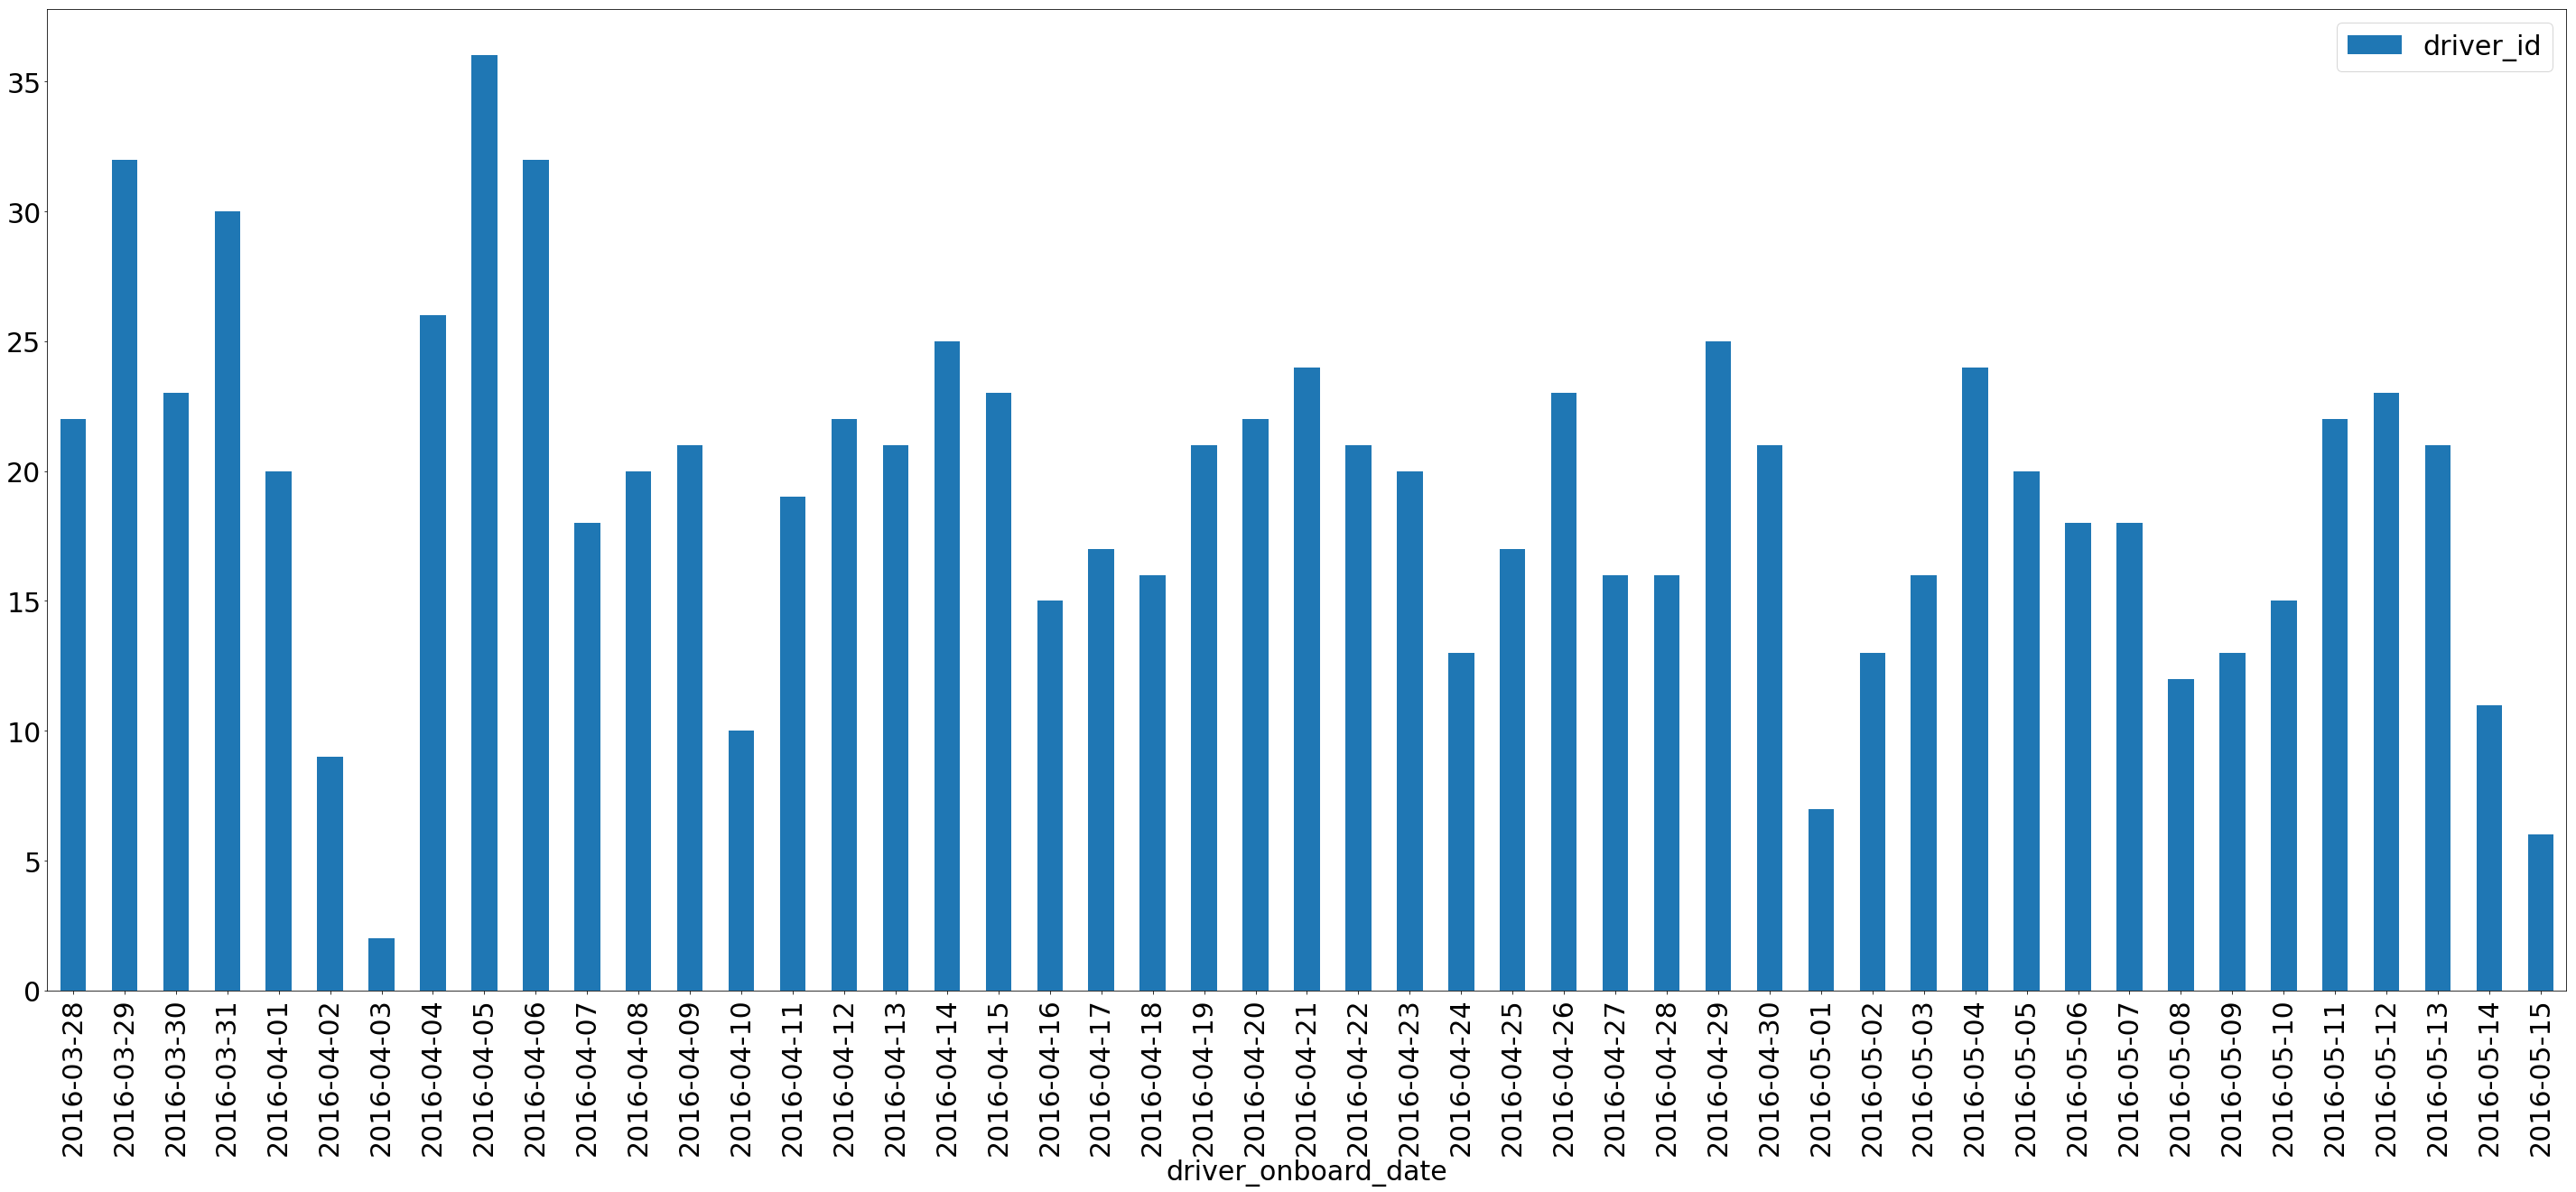

In [136]:
#look at driver onboard date distribution
plt.rcParams.update({'figure.figsize':[50,20], 'font.size':30})
driver.groupby(driver['driver_onboard_date']).count().plot(kind='bar')
plt.show()

The driver data sample contains drivers onboarded between 2016-03-28 to 2016-05-15, the distribution is fairly uniform with weekly cyclic pattern 

In [14]:
#import ride data and check summary
ride = pd.read_csv('ride_ids.csv')
ride.describe()

,ride_distance,ride_duration,ride_prime_time
count,193502.000000,193502.000000,193502.000000
mean,6955.218266,858.966099,17.305893
std,8929.444606,571.375818,30.825800
min,-2.000000,2.000000,0.000000
25%,2459.000000,491.000000,0.000000
50%,4015.000000,727.000000,0.000000
75%,7193.000000,1069.000000,25.000000
max,724679.000000,28204.000000,500.000000


There are records showing negative ride distance, it's probably due to data tracking error which need to be removed

In [24]:
#check missing value
ride.isnull().sum()

driver_id          0
ride_id            0
ride_distance      0
ride_duration      0
ride_prime_time    0
dtype: int64

In [25]:
#remove the records with negative ride distince 
ride = ride [ride['ride_distance']>0]
ride.describe()

,ride_distance,ride_duration,ride_prime_time
count,193315.000000,193315.000000,193315.000000
mean,6961.946290,859.633965,17.311254
std,8931.140532,571.122920,30.832015
min,1.000000,2.000000,0.000000
25%,2463.000000,492.000000,0.000000
50%,4020.000000,727.000000,0.000000
75%,7197.500000,1069.000000,25.000000
max,724679.000000,28204.000000,500.000000


In [53]:
#import ride ts data
ride_ts = pd.read_csv('ride_timestamps.csv')
ride_ts ['timestamp'] = pd.to_datetime(ride_ts ['timestamp'])
ride_ts.describe()

,ride_id,event,timestamp
count,970405,970405,970404
unique,194081,5,865826
top,51b44538f52ef231421b782e947b0b67,arrived_at,2016-04-30 22:09:15
freq,5,194081,7
first,NaN,NaN,2016-03-28 05:48:18
last,NaN,NaN,2016-06-27 00:50:50


In [54]:
#missing value? one timestamp is missing
ride_ts.isnull().sum()

ride_id      0
event        0
timestamp    1
dtype: int64

In [55]:
#what's the missing value
ride_ts[ride_ts.isnull().any(axis=1)]

,ride_id,event,timestamp
434222,72f0fa0bd86800e9da5c4dced32c8735,arrived_at,NaT


Since there is only one missing timestamp, we can do an imptation later to complete the data set

In [56]:
#data coherency check: to see if every ride has all 5 events
events_per_ride = ride_ts.groupby(['ride_id']).nunique()
events_per_ride.describe()

,ride_id,event,timestamp
count,194081.0,194081.0,194081.000000
mean,1.0,5.0,4.878391
std,0.0,0.0,0.329926
min,1.0,5.0,3.000000
25%,1.0,5.0,5.000000
50%,1.0,5.0,5.000000
75%,1.0,5.0,5.000000
max,1.0,5.0,5.000000


Event type is coherent, every ride has 5 unique events and no duplication in ride id

In [59]:
#pivot ride_ts table to make it convenient for future merging with ride data
ride_event = ride_ts.pivot(index='ride_id', columns='event', values='timestamp' )
ride_event.describe()

event,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at
count,194081,194080,194081,194081,194081
unique,190426,190526,190468,190524,190434
top,2016-06-02 16:00:22,2016-05-28 00:40:53,2016-06-03 18:59:26,2016-06-03 21:24:04,2016-05-06 20:39:08
freq,3,4,4,4,4
first,2016-03-28 05:48:23,2016-03-28 06:02:36,2016-03-28 06:37:51,2016-03-28 06:02:39,2016-03-28 05:48:18
last,2016-06-26 23:57:49,2016-06-27 00:02:03,2016-06-27 00:50:50,2016-06-27 00:02:06,2016-06-26 23:57:45


In [70]:
#Data coherency check: is any ride that has earilier event's ts behind the later event, 
#i.e. accepted ts behind picked up ts
print(ride_event.query('accepted_at<requested_at').empty)
print(ride_event.query('arrived_at<accepted_at').empty)
print(ride_event.query('picked_up_at<arrived_at').empty)
print(ride_event.query('dropped_off_at<picked_up_at').empty)

True
True
False
True


Some rides has pick up event happened before arrive at event, let's see what they look like

In [78]:
pd.options.mode.chained_assignment = None  # default='warn'

In [139]:
ride_pu_b4_aa = ride_event[ride_event['picked_up_at']<ride_event['arrived_at']]
ride_pu_b4_aa['ts_diff'] = (ride_pu_b4_aa['picked_up_at'] - ride_pu_b4_aa['arrived_at']).astype('timedelta64[s]')
ride_pu_b4_aa['ts_diff'].value_counts()

-1.0       5905
-2.0       1616
-3.0        139
-5.0         12
-4.0         11
-11.0        10
-10.0        10
-6.0         10
-8.0         10
-237.0        6
-13.0         6
-189.0        6
-12.0         6
-14.0         6
-35.0         5
-38.0         5
-219.0        5
-7.0          5
-248.0        5
-15.0         5
-201.0        5
-92.0         5
-67.0         5
-78.0         5
-18.0         5
-208.0        4
-9.0          4
-306.0        4
-414.0        4
-90.0         4
           ... 
-1116.0       1
-996.0        1
-3476.0       1
-277.0        1
-397.0        1
-126.0        1
-478.0        1
-1008.0       1
-428.0        1
-809.0        1
-228.0        1
-783.0        1
-144.0        1
-672.0        1
-960.0        1
-352.0        1
-88.0         1
-72.0         1
-697.0        1
-281.0        1
-451.0        1
-683.0        1
-1169.0       1
-980.0        1
-892.0        1
-2676.0       1
-267.0        1
-519.0        1
-1061.0       1
-903.0        1
Name: ts_diff, Length: 4

Most of the difference between pick up and arrive at events are less than 10 seconds, for these rides that have pickup happened before arrive at, we are going to assume pick up happened at the same time of arrive at

In [152]:
ride_event.head()

event,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at
ride_id,,,,,
00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 10:03:05,2016-06-13 09:44:33,2016-06-13 09:39:19
00005eae40882760d675da5effb89ae3,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:34:17,2016-05-14 05:26:18,2016-05-14 05:23:21
000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:54:18,2016-05-16 15:47:32,2016-05-16 15:43:09
00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:40:47,2016-05-11 19:35:15,2016-05-11 19:29:36
0000d9b24d8ccdd991b76258e616fa01,2016-04-26 18:12:15,2016-04-26 18:16:52,2016-04-26 18:24:14,2016-04-26 18:16:55,2016-04-26 18:11:38


In [151]:
#impute the timestamp of pick up to the same as arrive at timestamp for thoes rides have pick up happend before arrive at
for ride_id in ride_event['ride_id']:
    if ride_event['picked_up_at']<ride_event['arrived_at']:
        ride_event['picked_up_at']=ride_event['arrived_at']
#ride_event[ride_event['picked_up_at']<ride_event['arrived_at']]

KeyError: 'ride_id'

In [13]:
#use drop off ts as the completion time
ride_cmplt_ts = ride_ts[ride_ts['event']=='dropped_off_at']
ride_cmplt_ts.describe(

,ride_id,event,timestamp
count,194081,194081,194081
unique,194081,1,190468
top,51b44538f52ef231421b782e947b0b67,dropped_off_at,2016-06-03 18:59:26
freq,1,194081,4


In [25]:
ride = pd.read_csv('ride_ids.csv')

driver_ride = pd.merge(driver, ride, how= 'outer', left_on='driver_id', right_on='driver_id')

#driver_ride.isnull().sum()


driver_id                 0
driver_onboard_date    7611
ride_id                  83
ride_distance            83
ride_duration            83
ride_prime_time          83
dtype: int64